In [21]:
import pandas as pd

# Load
llm = pd.read_csv("barrier-choice-llm.csv")
dict_df = pd.read_csv("barrier_dictionary.csv")

# Join EXACTLY on the strings as-is
dict_small = dict_df[['barrier_label','barrier_id']].rename(
    columns={'barrier_label':'official_label', 'barrier_id':'dict_barrier_id'}
)
llm_fix = llm.merge(dict_small, on='official_label', how='left')

# Quick sanity check
unmatched = llm_fix['dict_barrier_id'].isna().sum()
print(f"Unmatched rows: {unmatched}")

if unmatched > 0:
    unmatched_labels = llm_fix.loc[llm_fix['dict_barrier_id'].isna(), 'official_label'].unique()
    print("Unmatched official_label values:")
    for label in unmatched_labels:
        print(f"- {label}")
    # Optionally, handle or drop unmatched rows here
    # llm_fix = llm_fix[llm_fix['dict_barrier_id'].notna()]

# Keep original id and overwrite with dictionary id
llm_fix['original_barrier_id'] = llm_fix['barrier_id']
llm_fix['barrier_id'] = llm_fix['dict_barrier_id']

# Save
llm_fix.to_csv("llm_barriers_corrected.csv", index=False)


Unmatched rows: 3
Unmatched official_label values:
- nan


In [ ]:
#select rows having no values at official label column
unmatched_rows = llm_fix[llm_fix['official_label'].isna()]

print(unmatched_rows)

In [ ]:
#clear iterations
import pandas as pd

# Load the corrected LLM file
llm = pd.read_csv("llm_barriers_corrected.csv")

# Make sure 'iteration' is numeric
llm['iteration'] = pd.to_numeric(llm['iteration'], errors='coerce')

# Inspect out-of-range iterations (optional)
out_of_range = llm[(llm['iteration'] < 0) | (llm['iteration'] > 49)]
print(f"Rows with iteration outside 0–49: {len(out_of_range)}")

# Keep only iterations 0..49
llm_trim = llm[(llm['iteration'] >= 0) & (llm['iteration'] <= 49)].copy()

# Quick audit per base_model × variant_id
summary = (
    llm_trim.groupby(['base_model','variant_id'])
            .agg(rows=('iteration','size'),
                 unique_iters=('iteration','nunique'))
            .reset_index()
            .sort_values(['base_model','variant_id'])
)
print(summary.head(20))

# (Optional) flag any variants missing iterations in 0..49
missing = summary[summary['unique_iters'] < 50]
if not missing.empty:
    print("Variants with <50 unique iterations (some runs missing):")
    print(missing)

# Save
llm_trim.to_csv("llm_barriers_50iter.csv", index=False)
print(f"Kept {len(llm_trim):,} rows (from {len(llm):,}). Saved to llm_barriers_50iter.csv")

print(llm_trim.shape)

In [31]:
import pandas as pd

df = pd.read_csv("llm_barriers_50iter.csv")
df['iteration'] = pd.to_numeric(df['iteration'], errors='coerce')

# unique iteration count per base model
iters_per_base = (
    df.groupby('base_model')['iteration']
      .nunique(dropna=True)
      .reset_index(name='unique_iterations')
      .sort_values('base_model')
)
print(iters_per_base)

# OPTIONAL: list missing iterations (should be empty lists if all 0..49 present)
all_iters = set(range(50))
missing_by_base = (
    df.dropna(subset=['iteration'])
      .groupby('base_model')['iteration']
      .apply(lambda s: sorted(all_iters - set(s.astype(int).unique())))
      .reset_index(name='missing_iterations')
      .sort_values('base_model')
)
print(missing_by_base)


    base_model  unique_iterations
0  deepseek-r1                 13
1   gemma3-12b                 50
2    llama-pro                 50
3      mistral                 50
4         phi4                 50
    base_model                                 missing_iterations
0  deepseek-r1  [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 2...
1   gemma3-12b                                                 []
2    llama-pro                                                 []
3      mistral                                                 []
4         phi4                                                 []


In [ ]:
#removing deepseek-r1
import pandas as pd

df = pd.read_csv("llm_barriers_50iter.csv")

# Case/space safe filter (keeps all non-deepseek rows)
mask = ~df['base_model'].astype(str).str.strip().str.lower().eq('deepseek-r1')
removed = (~mask).sum()
print(f"Rows to remove (deepseek-r1): {removed}")

df_clean = df.loc[mask].copy()
print(f"New row count: {len(df_clean)} (from {len(df)})")

# Save (choose one)
df_clean.to_csv("llm_barriers_50iter_clean.csv", index=False)   # new file
# df_clean.to_csv("llm_barriers_50iter.csv", index=False)           # overwrite


Rows to remove (deepseek-r1): 415
New row count: 6379 (from 6794)


In [33]:
#cleaning extra barriers
import pandas as pd
import numpy as np

INFILE  = "llm_barriers_50iter_clean.csv"
EXTRAS  = "barriers_extras_over5.csv"
OUTFILE = "llm_barriers_50iter_top5.csv"

df = pd.read_csv(INFILE)
df['iteration'] = pd.to_numeric(df['iteration'], errors='coerce')

# Sort so "first 5" is deterministic (timestamp, then row_id as tiebreaker)
sort_cols = ['base_model','variant_id','iteration','timestamp','row_id']
for c in ['timestamp','row_id']:
    if c not in df.columns:
        sort_cols.remove(c)
df = df.sort_values(sort_cols)

# Count rows per (base_model, variant_id, iteration)
keys = ['base_model','variant_id','iteration']
sizes = df.groupby(keys, dropna=False).size().reset_index(name='n')

# Identify groups with >5
over5 = sizes[sizes['n'] > 5]
print(f"Groups with >5 picks: {len(over5)}")

# Save ALL rows from the over-5 groups for audit
if len(over5):
    extras = df.merge(over5[keys], on=keys, how='inner')
    extras.to_csv(EXTRAS, index=False)
    print(f"Saved extras to {EXTRAS} ({len(extras)} rows).")
else:
    print("No groups exceed 5; extras file not created.")

# Trim: keep first 5 rows within each group
df['rank_in_group'] = df.groupby(keys).cumcount()
clean = df[df['rank_in_group'] < 5].drop(columns=['rank_in_group'])

# Report removals
removed_rows = len(df) - len(clean)
print(f"Removed {removed_rows} rows. Clean rows: {len(clean)}.")

# Save clean file
clean.to_csv(OUTFILE, index=False)
print(f"Saved clean file to {OUTFILE}")


Groups with >5 picks: 156
Saved extras to barriers_extras_over5.csv (1159 rows).
Removed 379 rows. Clean rows: 6000.
Saved clean file to llm_barriers_50iter_top5.csv


In [ ]:
#check if there are empty rows at 'official_label' column
df=pd.read_csv("llm_barriers_50iter_top5.csv")
empty_official_label = df[df['official_label'].isna()]
print(f"Empty rows in 'official_label': {len(empty_official_label)}")
print(empty_official_label.info())

In [40]:
import pandas as pd

LLM_IN  = "llm_barriers_50iter_top5.csv"
HUM_IN  = "barriers_human_final.csv"
OUT_FILE = "merged_barriers_zeroshot.csv"

# load
llm = pd.read_csv(LLM_IN)
hum = pd.read_csv(HUM_IN)

# ensure barrier_label is present in both
llm = llm.rename(columns={'official_label':'barrier_label'})
hum['barrier_label'] = hum['barrier_label']  # no-op, just to be explicit

# set source
llm['source'] = 'llm'
hum['source'] = 'human'

# add condition
llm['condition'] = 'ZEROSHOT'
hum['condition'] = 'ZEROSHOT'

# keep exactly these shared columns (in this order)
cols = [
    'row_id','source','base_model','variant_id','model',
    'barrier_id','barrier_label','iteration','timestamp','condition'
]

# some columns may be missing in human (base_model/variant_id/model/iteration/timestamp) → create if needed
for c in cols:
    if c not in llm.columns: llm[c] = pd.NA
    if c not in hum.columns: hum[c] = pd.NA

merged = pd.concat([hum[cols], llm[cols]], ignore_index=True)

# quick sanity (optional)
if 'barrier_id' in merged.columns:
    merged['barrier_id'] = pd.to_numeric(merged['barrier_id'], errors='coerce').astype('Int64')
    assert merged['barrier_id'].between(1,11).all(), "barrier_id outside 1..11"

merged.to_csv(OUT_FILE, index=False)
print("Saved:", OUT_FILE, "rows:", len(merged))

Saved: merged_barriers_zeroshot.csv rows: 6109


In [8]:
#analysis test
#import libraries
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import spearmanr, hypergeom
from statsmodels.stats.multitest import multipletests

FILE = "merged_barriers_zeroshot.csv"      # your merged csv
OUT_OVERALL = "results/barriers_results_overall.csv"
OUT_PER_BASE = "results/barriers_results_per_base.csv"
OUT_RATES = "results/barrier_selection_rates.csv"
#makedir
Path("results").mkdir(exist_ok=True)

B_PERM = 10000
B_BOOT = 5000
rng = np.random.default_rng(42)

def rates_from_rows(df):
    counts = df['barrier_id'].value_counts().reindex(range(1,12), fill_value=0).sort_index()
    total = counts.sum()
    return (counts/total).to_numpy() if total>0 else np.zeros(11)

def top5_idx(p): return (np.argsort(-p)[:5] + 1)  # 1..11

def hypergeo_p(overlap, M=11, n=5, N=5):
    return hypergeom.sf(overlap-1, M, n, N)  # P[X >= overlap]

def tv(p, q): return 0.5 * np.abs(p - q).sum()

def hellinger(p, q):
    return (1/np.sqrt(2)) * np.sqrt(((np.sqrt(p) - np.sqrt(q))**2).sum())

def spearman_perm(x, y, B=B_PERM, rng=rng):
    r_obs, _ = spearmanr(x, y)
    y_perm = y.copy()
    vals = np.empty(B)
    for b in range(B):
        rng.shuffle(y_perm)
        vals[b], _ = spearmanr(x, y_perm)
    p = float(np.mean(np.abs(vals) >= abs(r_obs)))
    return float(r_obs), p

def bootstrap_ci_metric(dfA, dfB, metric_fn, B=B_BOOT, rng=rng):
    nA, nB = len(dfA), len(dfB)
    a_idx = np.arange(nA); b_idx = np.arange(nB)
    vals = np.empty(B)
    for i in range(B):
        A = dfA.iloc[rng.choice(a_idx, nA, replace=True)]
        Bdf = dfB.iloc[rng.choice(b_idx, nB, replace=True)]
        vals[i] = metric_fn(rates_from_rows(A), rates_from_rows(Bdf))
    lo, hi = np.percentile(vals, [2.5, 97.5])
    return float(lo), float(hi)

# -------- load & minimal guards --------
df = pd.read_csv(FILE)
df['source'] = df['source'].astype(str).str.lower()
df = df.dropna(subset=['barrier_id']).copy()
df['barrier_id'] = pd.to_numeric(df['barrier_id'], errors='coerce').astype(int)
assert df['barrier_id'].between(1,11).all(), "barrier_id outside 1..11"

hum = df[df['source']=='human'].copy()
llm = df[df['source']=='llm'].copy()

# selection-rate vectors
pH = rates_from_rows(hum)
pL = rates_from_rows(llm)
per_base = {b: rates_from_rows(g) for b, g in llm.groupby('base_model')} if 'base_model' in llm.columns else {}

# also save the rate table for transparency
rate_rows = [{'unit':'human', 'type':'human', **{f'B{i}':pH[i-1] for i in range(1,12)}}]
rate_rows += [{'unit':'LLM_overall','type':'llm_overall', **{f'B{i}':pL[i-1] for i in range(1,12)}}]
for b, p in per_base.items():
    rate_rows.append({'unit':b, 'type':'base_model', **{f'B{i}':p[i-1] for i in range(1,12)}})
pd.DataFrame(rate_rows).to_csv(OUT_RATES, index=False)

# -------- Level 1: overall LLM vs human --------
rho_o, p_rho_o = spearman_perm(pH, pL)
H5, L5 = set(top5_idx(pH)), set(top5_idx(pL))
overlap_o = len(H5 & L5)
jacc_o = overlap_o / len(H5 | L5)
p_hyper_o = hypergeo_p(overlap_o)
tv_o = tv(pH, pL)
hell_o = hellinger(pH, pL)
tv_o_lo, tv_o_hi = bootstrap_ci_metric(hum, llm, tv)
hell_o_lo, hell_o_hi = bootstrap_ci_metric(hum, llm, hellinger)

overall = pd.DataFrame([{
    'comparison':'LLM overall vs Human',
    'spearman_rho':rho_o,
    'spearman_perm_p':p_rho_o,
    'tv':tv_o,'tv_ci_lo':tv_o_lo,'tv_ci_hi':tv_o_hi,
    'hellinger':hell_o,'hell_ci_lo':hell_o_lo,'hell_ci_hi':hell_o_hi,
    'top5_overlap':overlap_o,'top5_jaccard':jacc_o,'top5_hypergeo_p':p_hyper_o
}])
overall.to_csv(OUT_OVERALL, index=False)

# -------- Level 1b: per-base vs human --------
rows = []
for b, g in llm.groupby('base_model'):
    pB = per_base[b]
    rho, p_rho = spearman_perm(pH, pB)
    HB = set(top5_idx(pB))
    overlap = len(H5 & HB)
    jacc = overlap / len(H5 | HB)
    p_hg = hypergeo_p(overlap)
    tv_b = tv(pH, pB)
    hl_b = hellinger(pH, pB)
    tv_lo, tv_hi = bootstrap_ci_metric(hum, g, tv)
    hl_lo, hl_hi = bootstrap_ci_metric(hum, g, hellinger)
    rows.append(dict(
        base_model=b,
        spearman_rho=rho, spearman_perm_p=p_rho,
        tv=tv_b, tv_ci_lo=tv_lo, tv_ci_hi=tv_hi,
        hellinger=hl_b, hell_ci_lo=hl_lo, hell_ci_hi=hl_hi,
        top5_overlap=overlap, top5_jaccard=jacc, top5_hypergeo_p=p_hg
    ))
per_base_tbl = pd.DataFrame(rows)
for col in ['spearman_perm_p','top5_hypergeo_p']:
    per_base_tbl[col+'_bh'] = multipletests(per_base_tbl[col], method='fdr_bh')[1]
per_base_tbl = per_base_tbl.sort_values(['spearman_rho','tv','top5_jaccard'],
                                        ascending=[False, True, False]).reset_index(drop=True)
per_base_tbl.to_csv(OUT_PER_BASE, index=False)

print("Saved:\n ", OUT_OVERALL, "\n ", OUT_PER_BASE, "\n ", OUT_RATES)
print("\nOverall:\n", overall)
print("\nPer-base (top):\n", per_base_tbl.head())


Saved:
  results/barriers_results_overall.csv 
  results/barriers_results_per_base.csv 
  results/barrier_selection_rates.csv

Overall:
              comparison  spearman_rho  spearman_perm_p        tv  tv_ci_lo  \
0  LLM overall vs Human     -0.268351           0.4208  0.360884  0.279473   

   tv_ci_hi  hellinger  hell_ci_lo  hell_ci_hi  top5_overlap  top5_jaccard  \
0   0.45262   0.271675    0.229992    0.362045             0           0.0   

   top5_hypergeo_p  
0              1.0  

Per-base (top):
    base_model  spearman_rho  spearman_perm_p        tv  tv_ci_lo  tv_ci_hi  \
0  gemma3-12b      0.291955           0.3842  0.278073  0.221094  0.385510   
1        phi4      0.041191           0.9054  0.358807  0.284709  0.455566   
2     mistral     -0.421063           0.1942  0.599217  0.507453  0.687287   
3   llama-pro     -0.636171           0.0383  0.471187  0.393281  0.570932   

   hellinger  hell_ci_lo  hell_ci_hi  top5_overlap  top5_jaccard  \
0   0.310258    0.259537    0.

In [3]:
#computation of CIs
#import libraries
import pandas as pd
from pathlib import Path

# files you already produced
OVERALL_IN = Path("results/barriers_results_overall.csv")
PER_BASE_IN = Path("results/barriers_results_per_base.csv")
OUT_DIR = Path("results")
Path("results").mkdir(exist_ok=True)

# choose SESOI thresholds (pre-register these)
DELTA_TV = 0.10
DELTA_H  = 0.10

def equiv_call(lo, hi, delta):
    if hi <= delta: return "Equivalent"
    if lo >  delta: return "Not equivalent"
    return "Inconclusive"

# overall
overall = pd.read_csv(OVERALL_IN)
overall['tv_equiv']   = overall.apply(lambda r: equiv_call(r['tv_ci_lo'],   r['tv_ci_hi'],   DELTA_TV), axis=1)
overall['hell_equiv'] = overall.apply(lambda r: equiv_call(r['hell_ci_lo'], r['hell_ci_hi'], DELTA_H),  axis=1)
overall.to_csv("barriers_results_overall_equiv.csv", index=False)

# per base
per_base = pd.read_csv(PER_BASE_IN)
per_base['tv_equiv']   = per_base.apply(lambda r: equiv_call(r['tv_ci_lo'],   r['tv_ci_hi'],   DELTA_TV), axis=1)
per_base['hell_equiv'] = per_base.apply(lambda r: equiv_call(r['hell_ci_lo'], r['hell_ci_hi'], DELTA_H),  axis=1)
per_base.to_csv(OUT_DIR /"barriers_results_per_base_equiv.csv", index=False)

print("Saved: barriers_results_overall_equiv.csv, barriers_results_per_base_equiv.csv")


Saved: barriers_results_overall_equiv.csv, barriers_results_per_base_equiv.csv


In [8]:
#computation of CIs
#import libraries
import pandas as pd
from pathlib import Path

# files you already produced
OVERALL_IN = Path("results/barriers_results_overall.csv")
PER_BASE_IN = Path("results/barriers_results_per_base.csv")
OUT_DIR = Path("results")
Path("results").mkdir(exist_ok=True)

# choose SESOI thresholds (pre-register these)
DELTA_TV = 0.20
DELTA_H  = 0.20

def equiv_call(lo, hi, delta):
    if hi <= delta: return "Equivalent"
    if lo >  delta: return "Not equivalent"
    return "Inconclusive"

# overall
overall = pd.read_csv(OVERALL_IN)
overall['tv_equiv']   = overall.apply(lambda r: equiv_call(r['tv_ci_lo'],   r['tv_ci_hi'],   DELTA_TV), axis=1)
overall['hell_equiv'] = overall.apply(lambda r: equiv_call(r['hell_ci_lo'], r['hell_ci_hi'], DELTA_H),  axis=1)
overall.to_csv(OUT_DIR/"barriers_results_overall_equivSESOI.csv", index=False)

# per base
per_base = pd.read_csv(PER_BASE_IN)
per_base['tv_equiv']   = per_base.apply(lambda r: equiv_call(r['tv_ci_lo'],   r['tv_ci_hi'],   DELTA_TV), axis=1)
per_base['hell_equiv'] = per_base.apply(lambda r: equiv_call(r['hell_ci_lo'], r['hell_ci_hi'], DELTA_H),  axis=1)
per_base.to_csv(OUT_DIR/"barriers_results_per_base_equivSESOI.csv", index=False)

print("Saved: barriers_results_overall_equivSESOI.csv, barriers_results_per_base_equivSESOI.csv")


Saved: barriers_results_overall_equivSESOI.csv, barriers_results_per_base_equivSESOI.csv


C:\Users\HP\AppData\Local\Temp\ipykernel_13840\1892100820.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  display_index = df['unit'].replace(label_map)


Saved: results\barrier_selection_heatmap.png


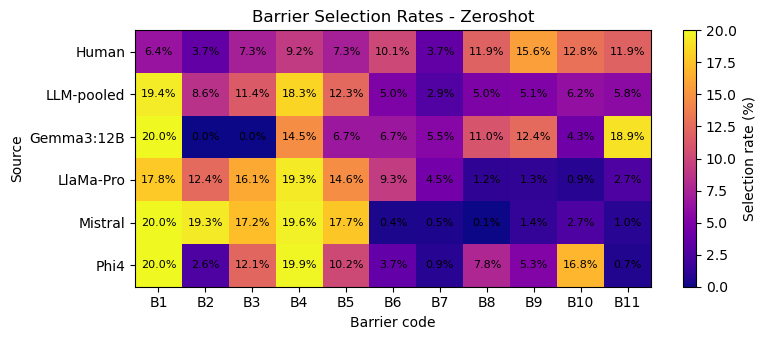

In [10]:
#selection rate heatmap
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

out_path=Path("results/barrier_selection_heatmap.png")

#load csv
df = pd.read_csv("results/barrier_selection_rates.csv")

# --- Customize label mapping and color map here ---
label_map = {
    "human": "Human",
    "LLM_overall": "LLM-pooled",
    "gemma3-12b": "Gemma3:12B",
    "llama-pro": "LlaMa-Pro",
    "mistral": "Mistral",
    "phi4": "Phi4"
}
cmap_name = "plasma"   # examples: 'viridis', 'plasma', 'inferno', 'magma', 'cividis'

# Keep order as given
df['unit'] = pd.Categorical(df['unit'].astype(str), categories=df['unit'].astype(str).tolist(), ordered=True)
display_index = df['unit'].replace(label_map)

# Select barrier columns
barrier_cols = [f'B{i}' for i in range(1, 12)]
Z = (df[barrier_cols] * 100).to_numpy()  # Convert to percentages

# Create heatmap
fig, ax = plt.subplots(figsize=(8, 3.5))
im = ax.imshow(Z, aspect='auto', cmap=cmap_name)

# Axes ticks/labels
ax.set_xticks(np.arange(len(barrier_cols)))
ax.set_xticklabels(barrier_cols, rotation=0)
ax.set_yticks(np.arange(len(display_index)))
ax.set_yticklabels(display_index)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Selection rate (%)")

# Annotate cells with percentages
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        ax.text(j, i, f"{Z[i, j]:.1f}%", ha="center", va="center", fontsize=8)

# Labels and title
ax.set_title("Barrier Selection Rates - Zeroshot")
ax.set_xlabel("Barrier code")
ax.set_ylabel("Source")

plt.tight_layout()

# Save file for download as well
plt.savefig(out_path, dpi=200, bbox_inches="tight")
out_path
print("Saved:", out_path)

In [1]:
# Compute Jaccard similarity of top-5 barrier selections
import os
import pandas as pd

csv_path = "results/barrier_selection_rates.csv"
    # Read data
df = pd.read_csv(csv_path)

    # Identify barrier columns (B1..B11)
barrier_cols = [c for c in df.columns if c.startswith("B")]
if len(barrier_cols) == 0:
        raise ValueError("No barrier columns found (expected columns like B1..B11).")

    # Normalize values if they look like proportions (0–1)
max_val = pd.to_numeric(df[barrier_cols].stack(), errors="coerce").max()
if pd.notna(max_val) and max_val <= 1 + 1e-9:
        df[barrier_cols] = df[barrier_cols] * 100.0

    # Helper: get top-5 barrier codes for a unit (by descending value, then stable order)
def top5_for_unit(row):
        # row is a Series for one unit
    vals = row[barrier_cols]
        # Sort by value desc, then by barrier name as a deterministic tie-breaker
    order = vals.sort_values(ascending=False, kind="mergesort")
    top5 = list(order.iloc[:5].index)
    return top5

# Build a dict: unit -> top5 set
top5_map = {}
for _, r in df.iterrows():
    unit = str(r["unit"])
    top5_map[unit] = set(top5_for_unit(r))

# Define the specific pairs to evaluate
pairs = [
    ("human", "LLM_overall"),
    ("human", "gemma3-12b"),
    ("human", "llama-pro"),
    ("human", "mistral"),
    ("human", "phi4"),
    ]

results = []
for a, b in pairs:
        if a not in top5_map or b not in top5_map:
            results.append({
                "pair": f"{a} vs {b}",
                "jaccard_top5": None,
                "intersection_size": None,
                "setA_top5": list(top5_map.get(a, [])),
                "setB_top5": list(top5_map.get(b, [])),
                "note": "One or both units not found in the file."
            })
            continue

        A = top5_map[a]
        B = top5_map[b]
        inter = len(A & B)
        union = len(A | B)
        jacc = inter / union if union else 0.0

        results.append({
            "pair": f"{a} vs {b}",
            "jaccard_top5": round(jacc, 3),
            "intersection_size": inter,
            "setA_top5": sorted(list(A)),
            "setB_top5": sorted(list(B))
        })

out_df = pd.DataFrame(results)

    # Save results
out_csv = "results/jaccard_top5_barriers.csv"
out_df.to_csv(out_csv, index=False)

print(f"Saved results to {out_csv}")


Saved results to results/jaccard_top5_barriers.csv
